# Loading Data & EDA

### Importing Libraries

In [92]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from tqdm import tqdm

In [93]:
import textacy
import textacy.preprocessing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
import nltk
import re, string
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import wordnet
from spacy import lookups, lemmatizer

In [94]:
# define the text library for use 
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

# taking stopwords from nltk
stop_words = nltk.corpus.stopwords.words("english")

#amend stop words, removing news as this will be used for the news datsaset
stop_words.append("news")
stop_words.append("new")
stop_words.remove("s")

### Importing Data & Preliminary EDA

#### Importing Data

In [95]:
raw_data_post_2016 = pd.read_csv('/Users/samholt/GA/CapstoneProject_RedditData_2016-19_raw.csv', sep = ",")

In [96]:
raw_data_pre_2015 = pd.read_csv('/Users/samholt/GA/CapstoneProjectRedditData_Raw2015.csv', sep = ",")

In [97]:
#checking for data type match
raw_data_pre_2015.dtypes == raw_data_post_2016.dtypes

created_utc     True
author          True
title           True
selftext        True
subreddit       True
num_comments    True
score           True
stickied        True
dtype: bool

In [98]:
#checking for columns match
raw_data_post_2016.columns == raw_data_pre_2015.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [99]:
#merging the two datasets 
raw_data = pd.concat([raw_data_pre_2015, raw_data_post_2016], ignore_index= True)

#### Exploring Data

In [100]:
#null count shows we have most of the information for all variables, only significant area we are missing is in selftext
raw_data.info(null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5450962 entries, 0 to 5450961
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   created_utc   5450962 non-null  int64 
 1   author        5450962 non-null  object
 2   title         5450953 non-null  object
 3   selftext      1705958 non-null  object
 4   subreddit     5450962 non-null  object
 5   num_comments  5450962 non-null  int64 
 6   score         5450962 non-null  int64 
 7   stickied      5450962 non-null  bool  
dtypes: bool(1), int64(3), object(4)
memory usage: 296.3+ MB


In [253]:
raw_data[raw_data["subreddit"] == "Anxiety"] 

,author,title,selftext,subreddit,num_comments,score,stickied,date,datetime,year
570,jenniferjuniper,Tolerating Uncertainty - one of the key milest...,,Anxiety,2,2,False,2012-09-12,2012-09-12 19:50:10,2012
571,Subhazard,"This song helps me with my Health Anxiety, all...",,Anxiety,0,7,False,2012-12-24,2012-12-24 09:31:06,2012
572,SamWalt,"If anyone wants a good laugh, The Onion hits t...",,Anxiety,16,181,False,2013-05-30,2013-05-30 21:09:12,2013
573,patentman11,Great book for dealing with anxiety and panic ...,,Anxiety,0,0,False,2014-03-19,2014-03-19 07:06:02,2014
574,sammihamilton,I created a website for those looking for some...,,Anxiety,4,1,False,2014-01-03,2014-01-03 13:42:30,2014
...,...,...,...,...,...,...,...,...,...,...
5263010,galapagosisland,I am in the middle of rock bottom right now. W...,Everything sucks right now. My future plans fa...,Anxiety,50,252,False,2018-02-23,2018-02-23 16:25:01,2018
5263012,wakingdemons,Please stop making anxiety and mental health s...,,Anxiety,61,252,False,2017-05-03,2017-05-03 15:44:25,2017
5263020,kittycate0530,Anyone else get anxious about posting on reddi...,I can't even remember how many times Ive writt...,Anxiety,50,508,False,2017-08-05,2017-08-05 03:07:35,2017
5263063,Toby95,How do you guys deal with telephobia?,For some absurd reason I have always had terri...,Anxiety,71,254,False,2018-06-25,2018-06-25 10:23:03,2018


In [101]:
#dropping rows where title is missing
raw_data.dropna(subset = ["title"], inplace=True)

In [102]:
#checking number of posts for each sub-reddit, unsurprisingly r/news represents the bulk of posts
raw_data["subreddit"].value_counts()

news            3942404
depression       800407
SuicideWatch     316914
Anxiety          255025
bipolar          136203
Name: subreddit, dtype: int64

In [103]:
#majority of news posts have no self-text, with the link included with the headline (excluded from this analyses as the headline & number score/comments used as the estimate if exposure to type of news)
pd.pivot_table(raw_data[["subreddit", "selftext"]],
               values = "selftext", index = "subreddit", aggfunc= "count")

,selftext
subreddit,
Anxiety,236536
SuicideWatch,303466
bipolar,113269
depression,775295
news,277385


In [104]:
#setting self text to blank where values are missing
raw_data.fillna("", inplace= True)
raw_data.info(null_counts= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5450953 entries, 0 to 5450961
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   created_utc   5450953 non-null  int64 
 1   author        5450953 non-null  object
 2   title         5450953 non-null  object
 3   selftext      5450953 non-null  object
 4   subreddit     5450953 non-null  object
 5   num_comments  5450953 non-null  int64 
 6   score         5450953 non-null  int64 
 7   stickied      5450953 non-null  bool  
dtypes: bool(1), int64(3), object(4)
memory usage: 337.9+ MB


In [105]:
raw_data.head()

,created_utc,author,title,selftext,subreddit,num_comments,score,stickied
0,1405690362,pallytank,Malaysia Airlines MH17: Signals intercepts rev...,,news,1,65,False
1,1323749158,rottenart,Jerry Sandusky will face his accusers for the ...,,news,2,6,False
2,1372811633,zzb211,Yale sues Yale,,news,0,2,False
3,1366920797,heyenikin,Four female prison guards impregnated by same ...,,news,1,2,False
4,1342644261,tangle82,Journalists revolt against Obama-Romney censor...,,news,0,0,False


In [106]:
raw_data.tail()

,created_utc,author,title,selftext,subreddit,num_comments,score,stickied
5450957,1524445619,thr0wqkq,I'm a pedophile and I deserve to die,I wanna die so much. I've never done anything ...,SuicideWatch,173,308,False
5450958,1558986063,UNCL_RCO,i just want someone to acknowledge me,upvote this. comment. do anything. i just want...,SuicideWatch,174,2487,False
5450959,1493828057,Icegreen9,So I bought a new gun. Tonight is the night,My pathetic life finally comes to an end tonig...,SuicideWatch,178,81,False
5450960,1562857107,[deleted],Wife committed suicide yesterday,[deleted],SuicideWatch,201,1705,False
5450961,1529102710,[deleted],Ugly people seem to have no value,[removed],SuicideWatch,226,122,False


In [107]:
pd.set_option('float_format', '{:f}'.format)
raw_data.describe()

,created_utc,num_comments,score
count,5450953.000000,5450953.000000,5450953.000000
mean,1465040137.651989,8.811481,41.466739
std,67206031.606137,156.124526,1048.962792
min,1202408298.000000,-3.000000,0.000000
25%,1419356023.000000,0.000000,1.000000
50%,1473798100.000000,0.000000,1.000000
75%,1518233750.000000,1.000000,2.000000
max,1567295997.000000,44006.000000,184864.000000


In [108]:
# checking for type of stickied posts
print(len(raw_data[raw_data["stickied"] == True]))
raw_data[raw_data["stickied"] == True].head(10)

37


,created_utc,author,title,selftext,subreddit,num_comments,score,stickied
4360143,1566994437,AutoModerator,"Wednesday Wins - August 28, 2019",What have you accomplished this week? Share yo...,Anxiety,2,3,True
4367492,1511769606,anxietymods,Welcome Newcomers &amp; QOTW: When you have fr...,Greetings &amp; Salutations!\n \nUse th...,Anxiety,74,11,True
4424907,1566816514,sweetpea122,MED MONDAYS,Med related discussion,bipolar,42,14,True
4425060,1495745318,sweetpea122,AS MODS WE NEED YOUR URGENT HELP TO KEEP A BAN...,We banned a user for this comment http://imgur...,bipolar,92,160,True
4470895,1512318313,sweetpea122,SELF-CARE SUNDAY,Post your self care plans,bipolar,11,4,True
4640438,1566735329,AutoModerator,"Sunday General Chat Thread - August 25, 2019","""Happy Sunday! What does your week look like?\...",Anxiety,13,2,True
4640627,1566389631,AutoModerator,"Wednesday Wins - August 21, 2019",What have you accomplished this week? Share yo...,Anxiety,15,7,True
4640821,1512201605,anxietymods,Share Your Victories Large &amp; Small! - Satu...,As I'm sure many of you already know first-han...,Anxiety,18,5,True
4651188,1505215302,sweetpea122,Update on Policy For New Accounts and 30 Day R...,We have instituted a 30 day new account review...,bipolar,17,41,True
4735913,1521857887,anxietymods,Welcome Newcomers &amp; QOTW - 2018-03-23,Greetings &amp; Salutations Everyone! \n ...,Anxiety,28,11,True


In [109]:
raw_data.shape

(5450953, 8)

In [110]:
# dropping posts which are stickied, very few and are typically mod messages 
raw_data = raw_data[raw_data["stickied"] == False]

In [111]:
#create date variable
raw_data["date"] = [dt.datetime.utcfromtimestamp(i).replace(minute=0, hour=0, second=0, microsecond=0) for i in raw_data["created_utc"]]
raw_data["datetime"] = [dt.datetime.utcfromtimestamp(i)for i in raw_data["created_utc"]]


In [112]:
#drop created_utc
raw_data.drop(labels = "created_utc", axis = 1, inplace= True)
raw_data

,author,title,selftext,subreddit,num_comments,score,stickied,date,datetime
0,pallytank,Malaysia Airlines MH17: Signals intercepts rev...,,news,1,65,False,2014-07-18,2014-07-18 13:32:42
1,rottenart,Jerry Sandusky will face his accusers for the ...,,news,2,6,False,2011-12-13,2011-12-13 04:05:58
2,zzb211,Yale sues Yale,,news,0,2,False,2013-07-03,2013-07-03 00:33:53
3,heyenikin,Four female prison guards impregnated by same ...,,news,1,2,False,2013-04-25,2013-04-25 20:13:17
4,tangle82,Journalists revolt against Obama-Romney censor...,,news,0,0,False,2012-07-18,2012-07-18 20:44:21
...,...,...,...,...,...,...,...,...,...
5450957,thr0wqkq,I'm a pedophile and I deserve to die,I wanna die so much. I've never done anything ...,SuicideWatch,173,308,False,2018-04-23,2018-04-23 01:06:59
5450958,UNCL_RCO,i just want someone to acknowledge me,upvote this. comment. do anything. i just want...,SuicideWatch,174,2487,False,2019-05-27,2019-05-27 19:41:03
5450959,Icegreen9,So I bought a new gun. Tonight is the night,My pathetic life finally comes to an end tonig...,SuicideWatch,178,81,False,2017-05-03,2017-05-03 16:14:17
5450960,[deleted],Wife committed suicide yesterday,[deleted],SuicideWatch,201,1705,False,2019-07-11,2019-07-11 14:58:27


#### Understand Correlation between Target & Predictor

In [113]:
#create list of unique dates between both
#start date
dt.datetime(2008, 2, 7, 0,0,0)
#end date
dt.datetime(2019, 8, 31, 0,0,0)

datelist = pd.DataFrame(pd.date_range(start= dt.datetime(2008,2,7,0,0,0), end= dt.datetime(2019, 8, 31, 0,0,0)).tolist())
datelist.columns = ["date"]

In [114]:
#get unique counts by date
post_date = datelist.join(pd.pivot_table(raw_data[["date","subreddit", "title"]], values = "title", index = "date", columns = "subreddit", aggfunc= "count"), on= "date", how= "left")
post_date.fillna(0, inplace = True)
post_date["Total_MH"] = post_date["Anxiety"] + post_date["SuicideWatch"] + post_date["bipolar"] + post_date["depression"]
post_date.set_index("date", inplace= True)
post_date.head()

,Anxiety,SuicideWatch,bipolar,depression,news,Total_MH
date,,,,,,
2008-02-07,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2008-02-08,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
2008-02-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-02-11,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000


In [115]:
post_date.shape

(4224, 6)

In [116]:
post_date.describe()

,Anxiety,SuicideWatch,bipolar,depression,news,Total_MH
count,4224.000000,4224.000000,4224.000000,4224.000000,4224.000000,4224.000000
mean,60.373343,75.025568,32.242661,189.487216,933.334280,357.128788
std,68.100242,78.272337,38.910294,198.004219,842.306846,379.361318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11.000000,0.000000,9.000000,127.000000,22.000000
50%,40.000000,56.000000,16.000000,132.000000,735.000000,247.000000
75%,95.000000,99.000000,53.000000,306.000000,1557.000000,550.250000
max,288.000000,382.000000,171.000000,801.000000,3219.000000,1498.000000


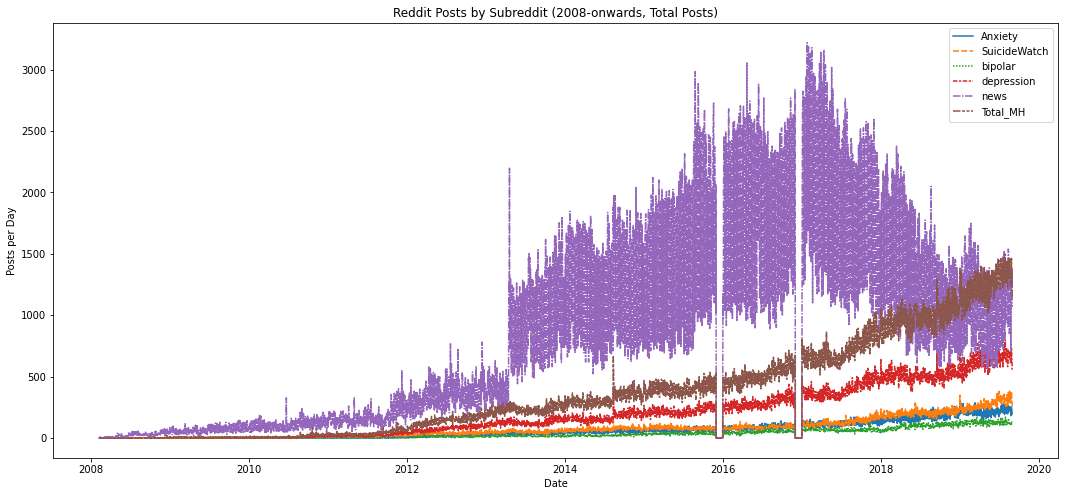

In [117]:
# visualize posts over time
f, ax = plt.subplots(figsize = (18,8))
sns.lineplot(data= post_date)
plt.title("Reddit Posts by Subreddit (2008-onwards, Total Posts)")
plt.xlabel("Date")
plt.ylabel("Posts per Day")
plt.show()

In [118]:
#data looks to pick up post 2011, dropping dates earlier than this
raw_data["year"] = [i.year for i in raw_data["date"]]

raw_data.drop(raw_data[raw_data["year"] < 2011].index , inplace = True)

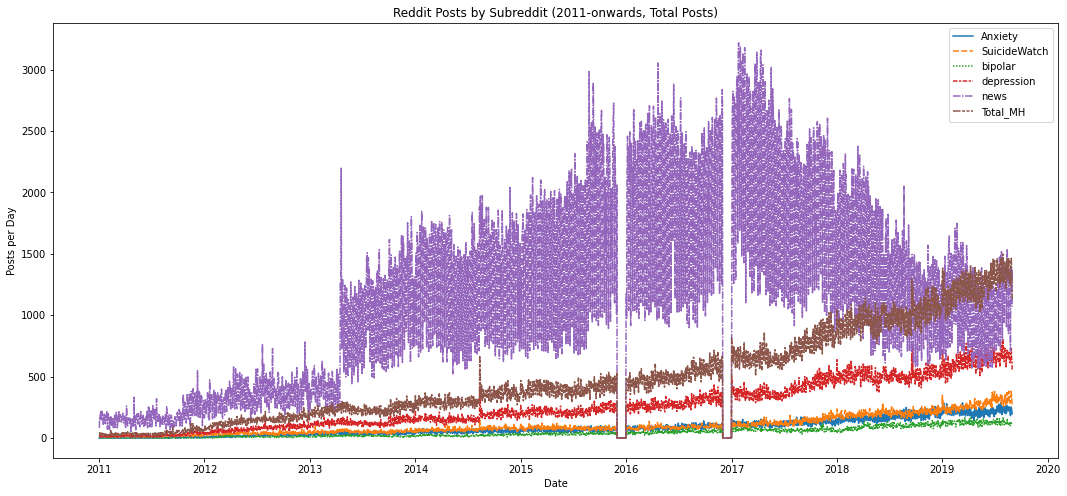

,Anxiety,SuicideWatch,bipolar,depression,news,Total_MH
date,,,,,,
2011-01-01,0.000000,16.000000,0.000000,17.000000,82.000000,33.000000
2011-01-02,0.000000,18.000000,0.000000,17.000000,90.000000,35.000000
2011-01-03,0.000000,23.000000,0.000000,20.000000,172.000000,43.000000
2011-01-04,0.000000,13.000000,0.000000,16.000000,153.000000,29.000000
2011-01-05,0.000000,20.000000,0.000000,13.000000,176.000000,33.000000
...,...,...,...,...,...,...
2019-08-27,251.000000,381.000000,110.000000,714.000000,1377.000000,1456.000000
2019-08-28,248.000000,369.000000,117.000000,729.000000,1381.000000,1463.000000
2019-08-29,234.000000,326.000000,128.000000,645.000000,1253.000000,1333.000000


In [119]:
#create list of unique dates between both
#start date
start = dt.datetime(2011, 1, 1, 0,0,0)
#end date
end = dt.datetime(2019, 8, 31, 0,0,0)

datelist = pd.DataFrame(pd.date_range(start= start, end= end).tolist())
datelist.columns = ["date"]
#get unique counts by date
post_date = datelist.join(pd.pivot_table(raw_data[["date","subreddit", "title"]], values = "title", index = "date", columns = "subreddit", aggfunc= "count"), on= "date", how= "left")
post_date.fillna(0, inplace = True)
post_date["Total_MH"] = post_date["Anxiety"] + post_date["SuicideWatch"] + post_date["bipolar"] + post_date["depression"]
post_date.set_index("date", inplace= True)

# visualize posts over time
f, ax = plt.subplots(figsize = (18,8))
sns.lineplot(data= post_date)
plt.title("Reddit Posts by Subreddit (2011-onwards, Total Posts)")
plt.xlabel("Date")
plt.ylabel("Posts per Day")
plt.show()
post_date

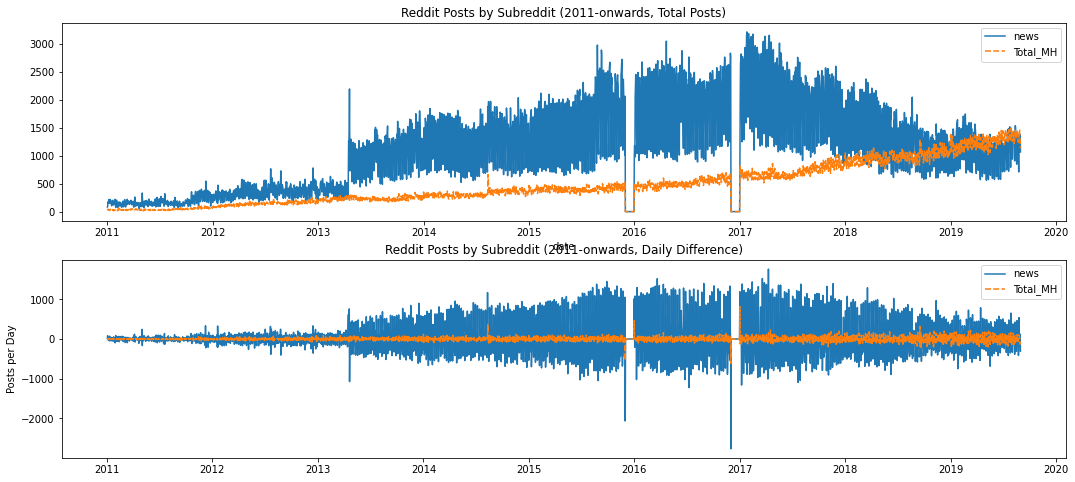

In [120]:
# visualize posts over time

f, (ax1, ax2) = plt.subplots(2, figsize = (18,8))


sns.lineplot(data= post_date[["news","Total_MH"]], ax = ax1).set_title("Reddit Posts by Subreddit (2011-onwards, Total Posts)")
sns.lineplot(data= post_date[["news","Total_MH"]].diff(), ax = ax2).set_title("Reddit Posts by Subreddit (2011-onwards, Daily Difference)")

plt.xlabel("")
plt.ylabel("Posts per Day")
plt.show()


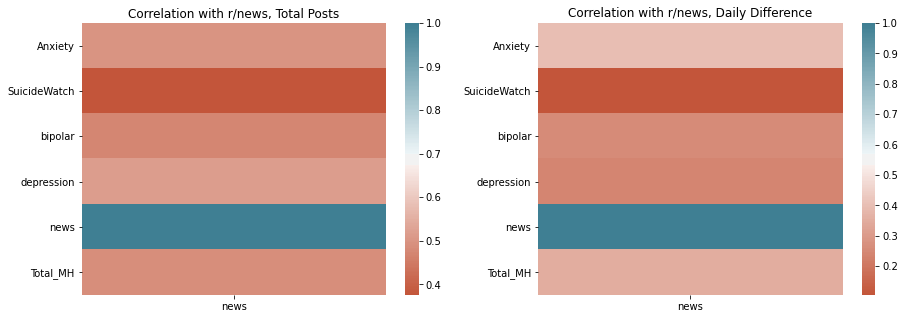

In [121]:
#understand correlation 
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

sns.heatmap(post_date.corr()[["news"]],cmap=sns.diverging_palette(20, 220, n=200), ax=ax1).set_title("Correlation with r/news, Total Posts")
sns.heatmap(post_date.diff().corr()[["news"]],cmap=sns.diverging_palette(20, 220, n=200), ax = ax2).set_title("Correlation with r/news, Daily Difference")
plt.show()

In [122]:
post_date.describe()

,Anxiety,SuicideWatch,bipolar,depression,news,Total_MH
count,3165.000000,3165.000000,3165.000000,3165.000000,3165.000000,3165.000000
mean,80.563665,98.517536,43.028752,252.113428,1221.236967,474.223381
std,67.552687,77.227868,39.453330,191.504606,784.525708,370.607367
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,44.000000,12.000000,100.000000,456.000000,188.000000
50%,63.000000,77.000000,30.000000,204.000000,1232.000000,376.000000
75%,121.000000,126.000000,66.000000,386.000000,1782.000000,699.000000
max,288.000000,382.000000,171.000000,801.000000,3219.000000,1498.000000


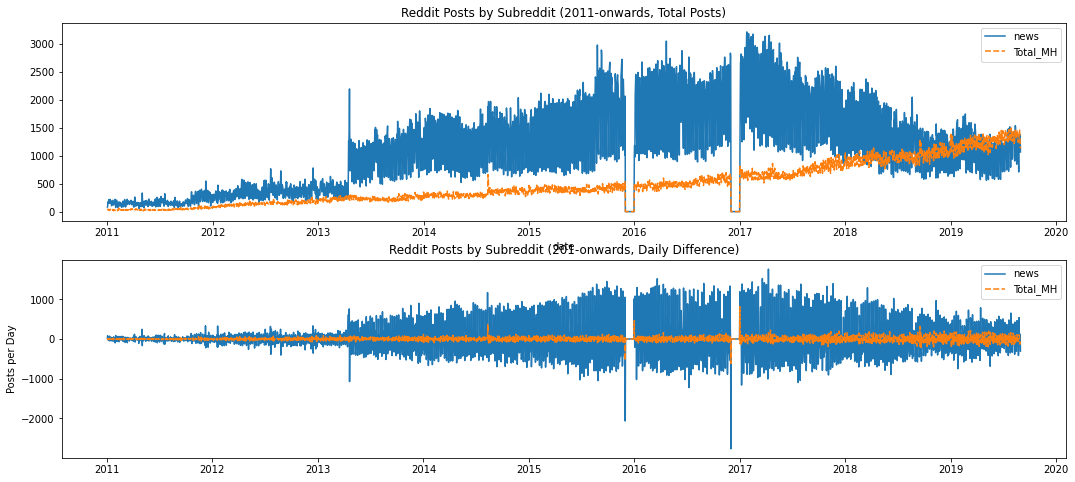

In [123]:
# visualize posts over time

f, (ax1, ax2) = plt.subplots(2, figsize = (18,8))


sns.lineplot(data= post_date[["news","Total_MH"]], ax = ax1).set_title("Reddit Posts by Subreddit (2011-onwards, Total Posts)")
sns.lineplot(data= post_date[["news","Total_MH"]].diff(), ax = ax2).set_title("Reddit Posts by Subreddit (201-onwards, Daily Difference)")

plt.xlabel("")
plt.ylabel("Posts per Day")
plt.show()


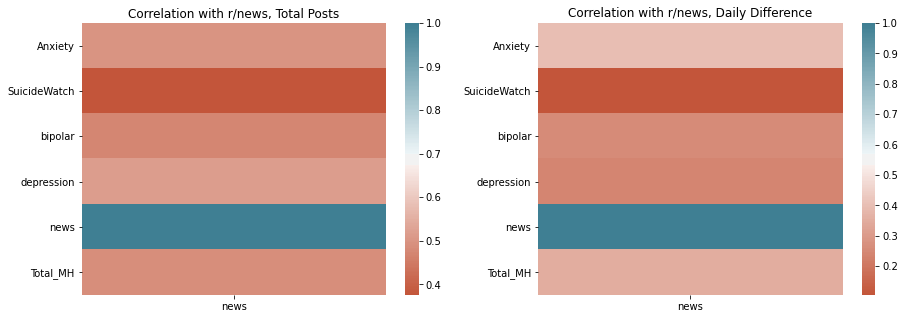

In [124]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

sns.heatmap(post_date.corr()[["news"]],cmap=sns.diverging_palette(20, 220, n=200), ax=ax1).set_title("Correlation with r/news, Total Posts")
sns.heatmap(post_date.diff().corr()[["news"]],cmap=sns.diverging_palette(20, 220, n=200), ax = ax2).set_title("Correlation with r/news, Daily Difference")
plt.show()

#### Understanding Impact of Day 

In [125]:
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [126]:
post_date["weekday_num"] = post_date.index.weekday

In [127]:
post_date["weekday"] = [weekdays[i] for i in post_date.index.weekday]

In [128]:
#post_date

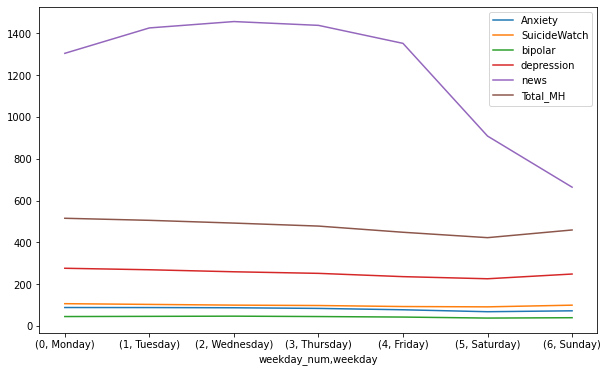

,,Anxiety,SuicideWatch,bipolar,depression,news,Total_MH
weekday_num,weekday,,,,,,
0,Monday,88.033186,106.384956,44.825221,275.860619,1304.345133,515.103982
1,Tuesday,87.803097,102.964602,45.741150,268.730088,1425.960177,505.238938
2,Wednesday,86.869469,99.449115,46.652655,259.068584,1456.422566,492.039823
3,Thursday,83.789823,97.606195,44.831858,251.500000,1438.234513,477.727876
4,Friday,77.276549,92.730088,42.349558,235.780973,1352.046460,448.137168
5,Saturday,67.924945,91.229581,37.545254,225.629139,908.470199,422.328918
6,Sunday,72.276549,99.274336,39.267699,248.283186,663.871681,459.101770


In [129]:
# appears to be no obvious change across weeks
post_date.groupby(["weekday_num","weekday"]).mean().plot(figsize=(10,6))
plt.show()
post_date.groupby(["weekday_num","weekday"]).mean()

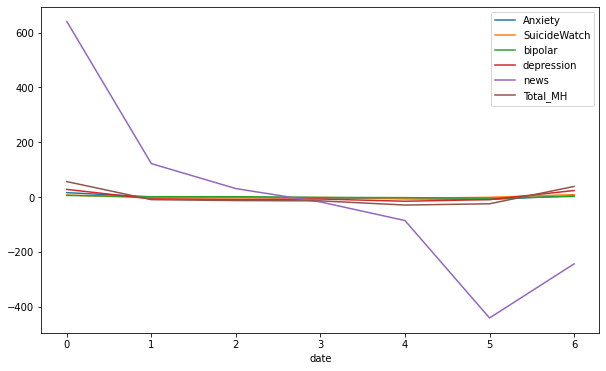

In [130]:
post_date.drop(["weekday", "weekday_num"], axis= 1).diff().groupby(post_date.index.weekday).mean().plot(figsize=(10,6))
plt.show()

In [131]:
post_date.columns

Index(['Anxiety', 'SuicideWatch', 'bipolar', 'depression', 'news', 'Total_MH',
       'weekday_num', 'weekday'],
      dtype='object')

In [132]:
raw_dtypes = raw_data.dtypes.to_dict()

raw_dtypes

{'author': dtype('O'),
 'title': dtype('O'),
 'selftext': dtype('O'),
 'subreddit': dtype('O'),
 'num_comments': dtype('int64'),
 'score': dtype('int64'),
 'stickied': dtype('bool'),
 'date': dtype('<M8[ns]'),
 'datetime': dtype('<M8[ns]'),
 'year': dtype('int64')}

#### Preliminary EDA Summary

* High discrepancy between posts per day for all subreddits over time, target and predictor variables will need to be standardised between each other for prediction
* Steady growth in all subreddits since 2008, potentially will use 2010 as the cut off point
* Significant increase in r/news from 2013 onwards, potentially related to some caching of old posts

### Variable Split & Feature Engineering

In [133]:
# split into target (depression related posts) and predictor (news posts) datasets
depression_data = raw_data[raw_data["subreddit"] != "news"].copy()
news_data = raw_data[raw_data["subreddit"] == "news"].copy()

### Cleaning News Posts
* Posts which have a low score/ number of comments and which are short are unlikely to be highly relevant to the overall sentiment as they have a high likelihood of being unseen, as well as being spam posts
* Removing these posts as they are unlikely to contribute the overall sentiment of a given day
* Removing user deleted posts as no information available for extract

#### Note on reddit scoring system
* reddit scoring system, basically negative & 0 voted appear similar, high score posts are promoted to front page so a strong indicator of visibility 
* Dummy code: votes = Max(upvotes - downvotes, 0); score = time + k*log(votes)


In [134]:
# tokenize headlines
def create_token(document):
    return [i.lower() for i in document.split(" ")]

In [135]:
# create token lengths to allow removal of unwanted posts 
news_data["token_len"] = [len(create_token(i)) for i in  news_data["title"]]

In [136]:
news_data.shape

(3865215, 11)

In [137]:
# large number of deleted by user posts, removing for completeness
# additional we see some posts have been posted multiple times, likely to be spam
news_data["title"].value_counts()

[deleted by user]                                                                                   3498
"Defense wanted to dismiss my case in it's entirety, Judge gave me 7weeks!"I am my own counsel!"    1735
"My second reply to the COP&amp;S!"                                                                 1623
“How these reaction are affecting me!"﻿                                                             1588
"What I felt like when I started these reactions called Botulism Toxin!"                            1530
                                                                                                    ... 
Teacup Poodle Breeders||Poodle Puppies for Sale in Canada                                              1
Would you spend $30,000 on a waterbed that vibrates with music?                                        1
Herkesin Merak Ettiği Akıllı Kumanda Ne İşe Yarar                                                      1
Try Out Luxury Adventure Today For An Unforgettable Exp

In [138]:
# removing deleted posts 
news_data = news_data[news_data["title"] != "[deleted by user]"].copy()

In [139]:
# removing posts which are defined as spam (appear more than once with score of 1)
#create dict of value counts
repeats_data = news_data["title"].value_counts().to_dict()

# add column for value counts
news_data["value_counts"] = [repeats_data[i] for i in news_data["title"]]

# filter out spam
news_data = news_data[(news_data["value_counts"] < 2) | (news_data["score"] > 1)].copy()


In [140]:
#removing posts which don't meet the spam criteria
news_data = news_data[(news_data["score"] > 1) | (news_data["num_comments"] > 5) | (news_data["token_len"] > 3)].copy()

In [141]:
news_data

,author,title,selftext,subreddit,num_comments,score,stickied,date,datetime,year,token_len,value_counts
0,pallytank,Malaysia Airlines MH17: Signals intercepts rev...,,news,1,65,False,2014-07-18,2014-07-18 13:32:42,2014,16,1
1,rottenart,Jerry Sandusky will face his accusers for the ...,,news,2,6,False,2011-12-13,2011-12-13 04:05:58,2011,11,1
2,zzb211,Yale sues Yale,,news,0,2,False,2013-07-03,2013-07-03 00:33:53,2013,3,1
3,heyenikin,Four female prison guards impregnated by same ...,,news,1,2,False,2013-04-25,2013-04-25 20:13:17,2013,8,3
4,tangle82,Journalists revolt against Obama-Romney censor...,,news,0,0,False,2012-07-18,2012-07-18 20:44:21,2012,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5263090,markeees,Spotify is being sued for $1.6 billion for usi...,,news,101,511,False,2018-01-03,2018-01-03 11:33:15,2018,15,1
5263091,conundrumbombs,Baton Rouge Officer Is Fired in Alton Sterling...,,news,363,511,False,2018-03-31,2018-03-31 02:48:09,2018,14,2
5263092,NinjaDiscoJesus,"One by One, ISIS Social Media Experts Are Kill...",,news,114,511,False,2016-11-25,2016-11-25 18:03:35,2016,14,1
5263093,cavehobbit,Anti-foreigner rally in Berlin draws ten times...,,news,720,1023,False,2016-03-13,2016-03-13 14:37:14,2016,11,1


#### Preparing Dataframe for Modelling

In [232]:
# create dataframe of unique posts 
df = pd.pivot_table(raw_data[["date", "datetime", "subreddit", "title"]], values = "title", index = ["date"], columns = "subreddit", aggfunc= "count")
df.fillna(0, inplace = True)
df["Total_MH"] = df["Anxiety"] + df["SuicideWatch"] + df["bipolar"] + df["depression"]



In [143]:
df

subreddit,Anxiety,SuicideWatch,bipolar,depression,news,Total_MH
date,,,,,,
2011-01-01,0.000000,16.000000,0.000000,17.000000,82.000000,33.000000
2011-01-02,0.000000,18.000000,0.000000,17.000000,90.000000,35.000000
2011-01-03,0.000000,23.000000,0.000000,20.000000,172.000000,43.000000
2011-01-04,0.000000,13.000000,0.000000,16.000000,153.000000,29.000000
2011-01-05,0.000000,20.000000,0.000000,13.000000,176.000000,33.000000
...,...,...,...,...,...,...
2019-08-27,251.000000,381.000000,110.000000,714.000000,1377.000000,1456.000000
2019-08-28,248.000000,369.000000,117.000000,729.000000,1381.000000,1463.000000
2019-08-29,234.000000,326.000000,128.000000,645.000000,1253.000000,1333.000000


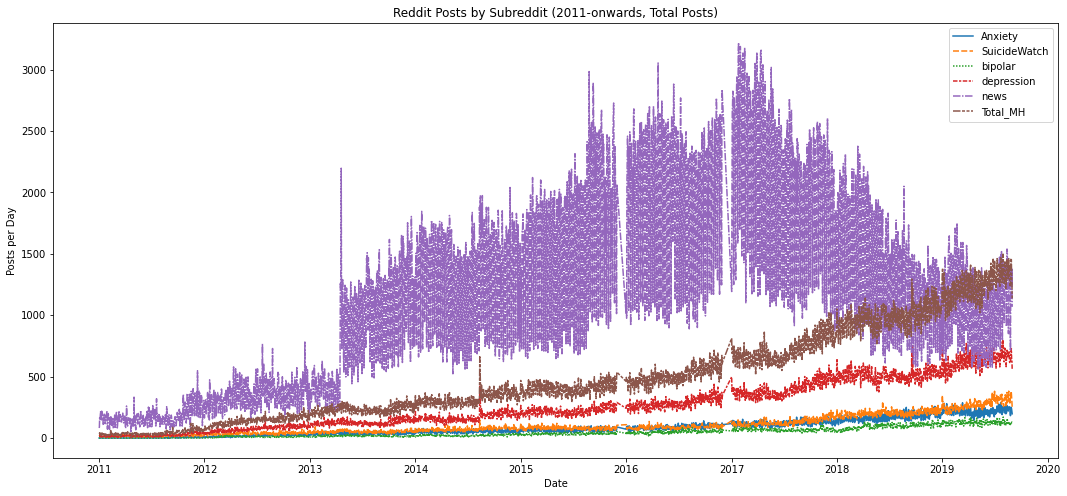

In [144]:
# visualize posts over time
f, ax = plt.subplots(figsize = (18,8))
sns.lineplot(data= df)
plt.title("Reddit Posts by Subreddit (2011-onwards, Total Posts)")
plt.xlabel("Date")
plt.ylabel("Posts per Day")
plt.show()

#### EDA & Feature Engineering: Natural Language Processing
* Creating predictor variables, sentiment, bag of words all weighted by comment score
* Sentiment uses weighted average based upon score
* Key bag of words weighted based upon score

#### Preprocessing for Bag of Words
* Given large amount of data, preprocessing steps will be done via functions to save preprocessing power


In [145]:
# remove punctuation from tokens
#check if reason s leaves
pattern1 = re.compile('[\W_]+')

def remove_punctuation(document):
    return ["".join(re.sub(pattern1,'', j)) for j in [i for i in document]]

In [146]:
# remove numbers
pattern2 = re.compile('[0-9]')
def remove_numbers(document): 
    return ["".join(re.sub(pattern2,'', j)) for j in [i for i in document]]

In [147]:
#remove nonetypes
def remove_nonetypes(document):
    return [x.lower() for x in document if x != ""]


In [148]:
# remove stop words from tokens
def remove_stopwords(token_list):
    return [i for i in token_list if i not in stop_words]

In [149]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# lemmatize tokens
wnl = WordNetLemmatizer()
def lemmatize_tokens(token_list):
    return [wnl.lemmatize(i, get_wordnet_pos(i)) for i in token_list]

In [150]:
stemmer = SnowballStemmer("english")
def stem_tokens(token_list):
    return [stemmer.stem(i) for i in token_list]

In [151]:
def create_corpus(corpus):
    stemmer = SnowballStemmer("english")
    pattern1 = re.compile('[\W_]+')
    pattern2 = re.compile('[0-9]')
    corpus2 = []
    for document in tqdm(corpus):
        document = create_token(document) #create tokens
        document = remove_punctuation(document) #remove punctuation
        document = remove_numbers(document) #remove numbers
        document = remove_stopwords(document) #remove stop words
        document = remove_nonetypes(document) #take away nonetypes left over from previous removals
        corpus2.append(document)
    return corpus2
        

In [152]:
#create processed tokens
tokens = create_corpus(news_data["title"])

100%|██████████| 3200007/3200007 [04:19<00:00, 12350.07it/s]


In [153]:
news_data["tokens"] = tokens

#### Sentiment Analyses

In [154]:
# adding Vader sentiment analyses scores
analyzer = SentimentIntensityAnalyzer()
vader_scores = news_data["title"].map(analyzer.polarity_scores)

In [155]:
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<3200007x4 sparse matrix of type '<class 'numpy.float64'>'
	with 12800028 stored elements in Compressed Sparse Row format>

In [156]:
for i, col in enumerate(dvec.feature_names_):
    news_data['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [157]:
news_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200007 entries, 0 to 5263094
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   author          3200007 non-null  object        
 1   title           3200007 non-null  object        
 2   selftext        3200007 non-null  object        
 3   subreddit       3200007 non-null  object        
 4   num_comments    3200007 non-null  int64         
 5   score           3200007 non-null  int64         
 6   stickied        3200007 non-null  bool          
 7   date            3200007 non-null  datetime64[ns]
 8   datetime        3200007 non-null  datetime64[ns]
 9   year            3200007 non-null  int64         
 10  token_len       3200007 non-null  int64         
 11  value_counts    3200007 non-null  int64         
 12  tokens          3200007 non-null  object        
 13  vader_compound  3200007 non-null  float64       
 14  vader_neg       32

In [158]:
#print most negative headlines
for title in news_data[news_data["score"] > 20].sort_values('vader_neg', ascending=False)['title'][0:20]:
    print(title)

Fuck
Suspected Monkey Murderer Arrested 
Paris attack fake victim jailed for fraud
Australian jailed for fake cancer scam
Melbourne terror attack suspect shot dead
Man attacks victim during racist rant
Yemen suicide attack kills 20+
Kabul suicide attack kills 11
NY attack suspect faces terror charges
Boston Suspect Arrested
Prison Riot in Mississippi Prison
East Area Rapist suspect arrested.
France thwarts suspected new terror attack
Florida police fatally shoot woman threatening suicide
Florida police fatally shoot woman threatening suicide
Foreclosure fraud whistleblower found dead
Suicide Molecules Kill Any Cancer Cell
Brussels attacks: Belgium releases terror murder suspect
Lawsuit blames schools for bullying, 8-year-old's suicide
Teens Arrested For Death Threats Against Steubenville Rape Victim


In [159]:
#print most positive headlines
for title in news_data[news_data["score"] > 20].sort_values('vader_pos', ascending=False)['title'][0:20]:
    print(title)

Obama wins.
My children laugh :)
2014 Pulitzer Prize Winners
Comedian wins Ukrainian presidency
Friend of Man Who Inspired 'Ice-Bucket Challenge' Dies Celebrating Success
Innocence Project helps free another man
Black Lives Matter awarded 2017 Sydney peace prize
Robert Mugabe wins China's 'Nobel Peace Prize'
Malala from Pakistan wins Nobel Peace Prize
Eagles Win Super Bowl LII
Broncos win Super Bowl 50
Beachgoers help rescue stranded great white shark
The lottery winner giving her winnings away
'The Onion' Wins Nobel Prize
Federal Reserve policy helping rich get richer
Senate approves USA Freedom Act
"Verizon supports FCC’s Restoring Internet Freedom Proposal"
Truth behind Freedom Industries bankruptcy
United Replaces Small Worker Bonuses With Chance to Win $100,000
Pistorius not guilty of murder


**Sentiment scores added to dataframe for modelling, sentiment per day averaged together with post sentiment weighted by post score in the final dataframe**

In [160]:
#function to created weighted average of sentiment 
def weighted_avg(group, variable, weight):
    d = group[variable]
    w = group[weight]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [161]:
news_data.groupby("date").apply(weighted_avg, "vader_compound", "score")

date
2011-01-01    0.188214
2011-01-02    0.213299
2011-01-03   -0.281094
2011-01-04   -0.201356
2011-01-05   -0.294761
                ...   
2019-08-27   -0.524220
2019-08-28   -0.305496
2019-08-29   -0.538780
2019-08-30   -0.504891
2019-08-31    0.117473
Length: 3103, dtype: float64

In [233]:
# adding sentiment scoring
for i in tqdm(['vader_compound', 'vader_neg', 'vader_neu', 'vader_pos']):
    df[i] = news_data.groupby("date").apply(weighted_avg, i , "score")

100%|██████████| 4/4 [00:41<00:00, 10.32s/it]


In [163]:
df.columns

Index(['Anxiety', 'SuicideWatch', 'bipolar', 'depression', 'news', 'Total_MH',
       'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos'],
      dtype='object', name='subreddit')

In [164]:
# saving before next step
df.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/MH_News_Processsed_Data.csv'")

#### Bag of Words & Topic Identification:
* Understanding words which discriminate more between documents, evaluates which words are more important to a document in the corpus
* 

In [165]:
from sklearn.feature_extraction.text import CountVectorizer

In [203]:
# creating dummy tokenizer as to process token lists
def dummy_tokenizer(document):
    return document

cvec = CountVectorizer(max_features= 200, tokenizer= dummy_tokenizer, preprocessor= dummy_tokenizer, ngram_range= (1,2))

# Fitting the vectorizer on tokens lists
cvec.fit(news_data['tokens'])

/Users/samholt/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=200, min_df=1,
                ngram_range=(1, 2),
                preprocessor=<function dummy_tokenizer at 0x3f188cf70>,
                stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function dummy_tokenizer at 0x3f188cf70>,
                vocabulary=None)

In [204]:
#transform tokens list 

df_word_count = pd.DataFrame(cvec.transform(news_data['tokens']).toarray(), columns= [i for i in cvec.get_feature_names()])

df_word_count.sum(axis= 0).sort_values(ascending= False)

us             120589
trump           79448
best            77306
police          75554
man             74744
                ...  
three           12722
research        12712
development     12611
price           12573
jobs            12538
Length: 200, dtype: int64

In [207]:
for i in df_word_count.columns:
    print(i)


accused
air
america
american
amp
arrested
attack
baby
back
ban
bangla
bangladesh
best
big
bill
billion
black
boy
business
buy
california
call
calls
car
care
case
charged
charges
child
children
china
city
claims
clinton
company
could
court
data
day
de
dead
deal
death
delhi
design
development
dies
donald
donald trump
dont
drug
el
en
facebook
family
fbi
federal
find
fire
first
florida
former
found
free
get
gets
girl
global
go
good
google
government
group
gun
health
help
high
home
house
india
industry
internet
jobs
judge
kids
killed
know
la
last
latest
law
life
like
live
los
make
man
market
marketing
may
media
men
military
million
money
murder
national
near
need
north
number
obama
office
officer
oil
old
one
online
pay
people
phone
plan
police
post
president
price
prison
public
real
report
research
review
right
rokambola
russia
sale
say
says
school
security
service
services
set
sex
shooting
shot
show
shows
social
south
state
states
stop
student
students
study
support
suspect
system
take
tax

In [211]:
#key words taken from the top 500 words found in the previous bag of words as well as additional words of interest
neg_word_counts = ["accused", "arrested", "attack", "business", "charged", "control", "crash", "dead", "death", "dies", "donald trump",
                    "drug", "fight", "found", "gay", "health", "isis", "kill", "killed", "killing",
                    "military", "murder", "obama", "prison", "police", "shooting", "shot", "syria", "tax", 
                    # additional words on top of those of interest from the top 500 across the corpus
                   "recession", "debt", "healthcare", "healthcare cost", "funding cut", "war", "terrorism", "inflation",
                   "rape", "torture", "suicide", "unemployment", "disease", "pandemic", "trump", "insurance", "pension",
                   "jail", "flood", "famine", "ebola"]

In [215]:
# postive words added
pos_word_counts = ["superbowl", "world cup", "win", "summer", "heatwave", "peace", "puppy", "lottery", "winning",
                   "jobs", "best", "free", "help", "development", "family", "love", "increase", "growth", "awarded",
                  "champion", "record", "cure", "growing", "improve", "olympics", "football", "qualify"]

In [216]:
key_words_counts = neg_word_counts + pos_word_counts

In [234]:
# creating CVEC based on key words of interest, partly based on top words from full corpus
cvec = CountVectorizer(vocabulary= key_words_counts, tokenizer= dummy_tokenizer, preprocessor= dummy_tokenizer, ngram_range= (1,2))

# Fitting the vectorizer on tokens lists
cvec.fit(news_data['tokens'])

/Users/samholt/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2),
                preprocessor=<function dummy_tokenizer at 0x3f188cf70>,
                stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function dummy_tokenizer at 0x3f188cf70>,
                vocabulary=['accused', 'arrested', 'attack', 'business',
                            'charged', 'control', 'crash', 'dead', 'death',
                            'dies', 'donald trump', 'drug', 'fight', 'found',
                            'gay', 'health', 'isis', 'kill', 'killed',
                            'killing', 'military', 'murder', 'obama', 'prison',
                            'police', 'shooting', 'shot', 'syria', 'tax',
                            'recession', ...

In [235]:
df_word_count = pd.DataFrame(cvec.transform(news_data['tokens']).toarray(), columns= [i for i in cvec.get_feature_names()])

df_word_count.sum(axis= 0).sort_values(ascending= False)

trump              79448
best               77306
police             75554
dead               34775
killed             31284
                   ...  
heatwave             168
famine               131
pandemic             125
funding cut           34
healthcare cost        5
Length: 77, dtype: int64

In [236]:
#function to created weighted average of bag of words 
def weighted(group, variable, weight):
    d = group[variable]
    w = group[weight]
    return (d * w).sum()
    

In [237]:
news_data.columns 

Index(['author', 'title', 'selftext', 'subreddit', 'num_comments', 'score',
       'stickied', 'date', 'datetime', 'year', 'token_len', 'value_counts',
       'tokens', 'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos',
       'test'],
      dtype='object')

In [238]:
word_count_columns = df_word_count.columns

In [239]:
word_count_columns

Index(['accused', 'arrested', 'attack', 'business', 'charged', 'control',
       'crash', 'dead', 'death', 'dies', 'donald trump', 'drug', 'fight',
       'found', 'gay', 'health', 'isis', 'kill', 'killed', 'killing',
       'military', 'murder', 'obama', 'prison', 'police', 'shooting', 'shot',
       'syria', 'tax', 'recession', 'debt', 'healthcare', 'healthcare cost',
       'funding cut', 'war', 'terrorism', 'inflation', 'rape', 'torture',
       'suicide', 'unemployment', 'disease', 'pandemic', 'trump', 'insurance',
       'pension', 'jail', 'flood', 'famine', 'ebola', 'superbowl', 'world cup',
       'win', 'summer', 'heatwave', 'peace', 'puppy', 'lottery', 'winning',
       'jobs', 'best', 'free', 'help', 'development', 'family', 'love',
       'increase', 'growth', 'awarded', 'champion', 'record', 'cure',
       'growing', 'improve', 'olympics', 'football', 'qualify'],
      dtype='object')

In [242]:
df_word_count["score"] = news_data["score"]
df_word_count["date"] = news_data["date"]

In [244]:
# adding key word counts  
for i in tqdm(key_words_counts):
    df[i + "_wgt"] = df_word_count.groupby("date").apply(weighted, i , "score")

100%|██████████| 77/77 [06:42<00:00,  5.22s/it]


In [245]:
# adding key word counts  
for i in tqdm(key_words_counts):
    df[i + "_ct"] = df_word_count.groupby("date")[i].sum()

100%|██████████| 77/77 [00:17<00:00,  4.53it/s]


In [246]:
date_1 =  df_word_count[df_word_count["date"] == "2011-01-02"]
date_2 =  df_word_count[df_word_count["date"] == "2011-01-08"]

In [247]:
date_1[50:70]

,accused,arrested,attack,business,charged,control,crash,dead,death,dies,...,champion,record,cure,growing,improve,olympics,football,qualify,score,date
1194768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,2011-01-02
1209891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,2011-01-02
1232339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.000000,2011-01-02
1238674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,2011-01-02
1323593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,2011-01-02
1341081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,2011-01-02
1363894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,2011-01-02
1375668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,2011-01-02
1405347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,2011-01-02
1485208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,2011-01-02


In [248]:
news_data[news_data["date"] == "2011-01-02"] 

,author,title,selftext,subreddit,num_comments,score,stickied,date,datetime,year,token_len,value_counts,tokens,vader_compound,vader_neg,vader_neu,vader_pos,test
2685,hackingpath,Wikimedia Foundation reaches $16 million fundr...,,news,0,1,False,2011-01-02,2011-01-02 10:20:06,2011,10,1,"[wikimedia, foundation, reaches, million, fund...",0.051600,0.000000,0.882000,0.118000,0.051600
33185,jean3xss,Divorce &amp; Family Law Attorneys,,news,0,1,False,2011-01-02,2011-01-02 03:49:11,2011,7,1,"[divorce, amp, family, law, attorneys]",0.000000,0.000000,1.000000,0.000000,0.000000
48792,MarvAlbertJr,Hey Trolls: Now your favorite hobby will set y...,,news,1,0,False,2011-01-02,2011-01-02 19:08:11,2011,16,1,"[hey, trolls, favorite, hobby, set, back, year...",0.458800,0.000000,0.833000,0.167000,0.000000
77562,vipez,23 yo Man arrested at Los Angeles airport with...,,news,2,5,False,2011-01-02,2011-01-02 10:19:35,2011,21,1,"[yo, man, arrested, los, angeles, airport, kg,...",-0.296000,0.129000,0.792000,0.079000,-1.480000
85757,patterson1nm,Illinois Criminal Defense Attorney,,news,0,1,False,2011-01-02,2011-01-02 04:11:09,2011,6,1,"[illinois, criminal, defense, attorney]",-0.440400,0.493000,0.290000,0.217000,-0.440400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937454,morris8yv,AL Attorneys,,news,1,1,False,2011-01-02,2011-01-02 05:04:24,2011,4,1,"[al, attorneys]",0.000000,0.000000,1.000000,0.000000,0.000000
1974623,MarvAlbertJr,Do you know the history of Israel: Get Educate...,,news,11,0,False,2011-01-02,2011-01-02 08:02:46,2011,10,1,"[know, history, israel, get, educated, america]",0.000000,0.000000,1.000000,0.000000,0.000000
1995256,newslive,Kenya Commercial Bank eyes south Sudan expansion,,news,0,1,False,2011-01-02,2011-01-02 11:34:09,2011,7,1,"[kenya, commercial, bank, eyes, south, sudan, ...",0.000000,0.000000,1.000000,0.000000,0.000000
2016628,lda6jsw,Sacramento Divorce Lawyer,,news,0,1,False,2011-01-02,2011-01-02 15:15:22,2011,5,1,"[sacramento, divorce, lawyer]",0.000000,0.000000,1.000000,0.000000,0.000000


In [249]:
news_data[news_data["date"] == "2011-01-08"]

,author,title,selftext,subreddit,num_comments,score,stickied,date,datetime,year,token_len,value_counts,tokens,vader_compound,vader_neg,vader_neu,vader_pos,test
609,shallah,Luxury Real Estate: The $60 Million Dream Hous...,,news,0,2,False,2011-01-08,2011-01-08 00:07:32,2011,46,1,"[luxury, real, estate, million, dream, house, ...",0.636900,0.000000,0.892000,0.108000,1.273800
619,[deleted],After days of contradictory reports citing unn...,,news,0,0,False,2011-01-08,2011-01-08 18:50:05,2011,31,1,"[days, contradictory, reports, citing, unnamed...",-0.340000,0.136000,0.795000,0.068000,-0.000000
5470,zensunnioracle,Oil from BP spill STILL killing marshlands in ...,,news,117,1029,False,2011-01-08,2011-01-08 02:01:31,2011,21,1,"[oil, bp, spill, still, killing, marshlands, l...",-0.557700,0.202000,0.654000,0.144000,-573.873300
21905,caffeinedependent,Illinois to raise income tax by 75%,,news,0,1,False,2011-01-08,2011-01-08 18:07:10,2011,7,1,"[illinois, raise, income, tax]",0.000000,0.000000,1.000000,0.000000,0.000000
65266,[deleted],Congresswoman's shooter's first Youtube video ...,,news,0,1,False,2011-01-08,2011-01-08 22:26:06,2011,10,1,"[congresswomans, shooters, first, youtube, vid...",0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991851,Stinkbait,Congresswoman Gabrielle Giffords Shot In Arizo...,,news,520,977,False,2011-01-08,2011-01-08 18:19:35,2011,8,1,"[congresswoman, gabrielle, giffords, shot, ari...",0.000000,0.000000,1.000000,0.000000,0.000000
2008199,davidreiss666,"U.S. Rep. Giffords shot in Arizona, guman held...",,news,0,3,False,2011-01-08,2011-01-08 19:17:35,2011,30,1,"[us, rep, giffords, shot, arizona, guman, held...",0.000000,0.000000,1.000000,0.000000,0.000000
2036809,EvolutionTheory,US Gulf Oil Spill Still Fouling Louisiana Marshes,,news,2,8,False,2011-01-08,2011-01-08 03:24:22,2011,8,1,"[us, gulf, oil, spill, still, fouling, louisia...",0.000000,0.000000,1.000000,0.000000,0.000000
2043189,[deleted],Real Life Superheroes in Seattle - ABC news,,news,0,0,False,2011-01-08,2011-01-08 11:53:30,2011,8,1,"[real, life, superheroes, seattle, abc]",0.000000,0.000000,1.000000,0.000000,0.000000


In [250]:
df_word_count = []

In [251]:
#final file to take through for processing
df.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/MH_News_Processsed_Data.csv'")